In [1]:
import openmeteo_requests
import requests_cache
from retry_requests import retry
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hopsworks

In [2]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
# Get data over a year
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 59.3294,
	"longitude": 18.0687,
	"start_date": "2018-01-01",
	"end_date": "2023-12-25",
	"hourly": ["temperature_2m", "apparent_temperature", "precipitation", "rain", "snowfall", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m"],
	"timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)


In [3]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_rain = hourly.Variables(3).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(4).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(5).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(6).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(7).ValuesAsNumpy()
hourly_cloud_cover_mid = hourly.Variables(8).ValuesAsNumpy()
hourly_cloud_cover_high = hourly.Variables(9).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(10).ValuesAsNumpy()
hourly_wind_speed_100m = hourly.Variables(11).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(12).ValuesAsNumpy()
hourly_wind_direction_100m = hourly.Variables(13).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(14).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
hourly_data["cloud_cover_high"] = hourly_cloud_cover_high
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_direction_100m"] = hourly_wind_direction_100m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

# Fill nans with last valid observation
hourly_dataframe = pd.DataFrame(data = hourly_data).fillna(method='ffill')

print(hourly_dataframe)

Coordinates 59.29701232910156°E 18.163265228271484°N
Elevation 24.0 m asl
Timezone b'Europe/Berlin' b'CET'
Timezone difference to GMT+0 3600 s
                     date  temperature_2m  apparent_temperature  \
0     2017-12-31 23:00:00           1.265             -3.031214   
1     2018-01-01 00:00:00           1.365             -2.281977   
2     2018-01-01 01:00:00           2.015             -1.806996   
3     2018-01-01 02:00:00           2.465             -1.194924   
4     2018-01-01 03:00:00           2.865             -0.409620   
...                   ...             ...                   ...   
52435 2023-12-25 18:00:00          -0.185             -3.219042   
52436 2023-12-25 19:00:00          -0.235             -3.228180   
52437 2023-12-25 20:00:00          -0.385             -3.208137   
52438 2023-12-25 21:00:00          -0.535             -3.178375   
52439 2023-12-25 22:00:00          -0.635             -3.888433   

       precipitation  rain  snowfall  surface_pressu

In [4]:
# Find nan items, the data is clean
print(hourly_dataframe[hourly_dataframe.isna().any(axis=1)])
# Check distribution of variables
hourly_dataframe.describe()

Empty DataFrame
Columns: [date, temperature_2m, apparent_temperature, precipitation, rain, snowfall, surface_pressure, cloud_cover, cloud_cover_low, cloud_cover_mid, cloud_cover_high, wind_speed_10m, wind_speed_100m, wind_direction_10m, wind_direction_100m, wind_gusts_10m]
Index: []


,date,temperature_2m,apparent_temperature,precipitation,rain,snowfall,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m
count,52440,52440.000000,52440.000000,52440.000000,52440.000000,52440.000000,52440.000000,52440.000000,52440.000000,52440.000000,52440.000000,52440.000000,52440.000000,52440.000000,52440.000000,52440.000000
mean,2020-12-28 10:29:59.999999744,7.810467,4.834694,0.074895,0.062548,0.008678,1009.147278,54.149643,37.545307,33.140560,38.385639,12.707273,22.405899,202.872482,203.283005,28.484606
min,2017-12-31 23:00:00,-16.434999,-21.731699,0.000000,0.000000,0.000000,956.997986,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.830296,0.462053,1.440000
25%,2019-07-01 04:45:00,1.515000,-2.698319,0.000000,0.000000,0.000000,1002.327423,14.100000,0.000000,0.000000,0.000000,9.021574,16.299694,140.527573,139.702442,19.440001
50%,2020-12-28 10:30:00,7.165000,3.859496,0.000000,0.000000,0.000000,1010.095062,54.300003,12.000000,10.000000,11.000000,12.181625,22.104116,216.528946,218.990997,27.000000
75%,2022-06-27 16:15:00,14.214999,12.470608,0.000000,0.000000,0.000000,1016.703339,100.000000,94.000000,73.000000,92.000000,15.815435,27.804029,273.813995,275.273804,36.000000
max,2023-12-25 22:00:00,31.415001,32.746426,11.100000,11.100000,2.800000,1045.847168,100.000000,100.000000,100.000000,100.000000,40.430737,65.489334,360.000000,360.000000,101.159996
std,NaN,8.165394,9.602337,0.314524,0.296517,0.068479,11.554664,39.407478,42.517815,39.552593,42.959423,5.380155,8.983235,94.495399,95.525406,12.346557


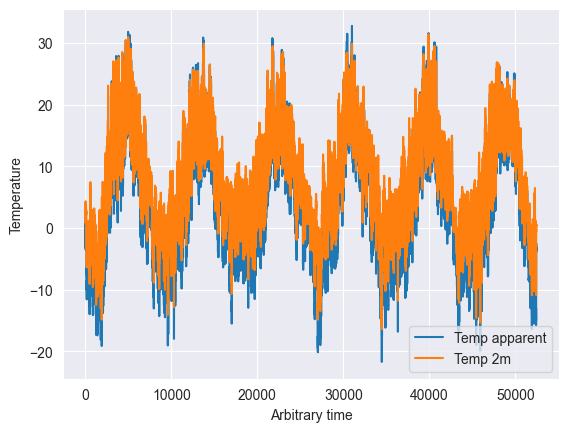

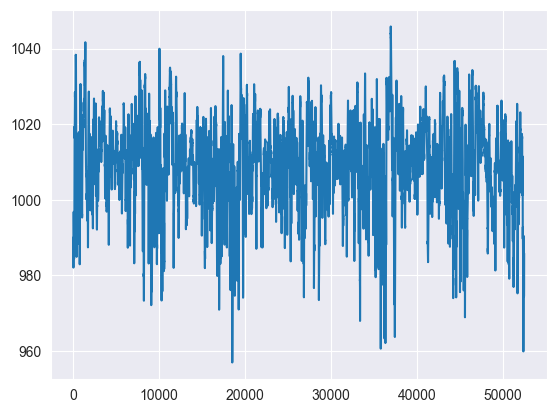

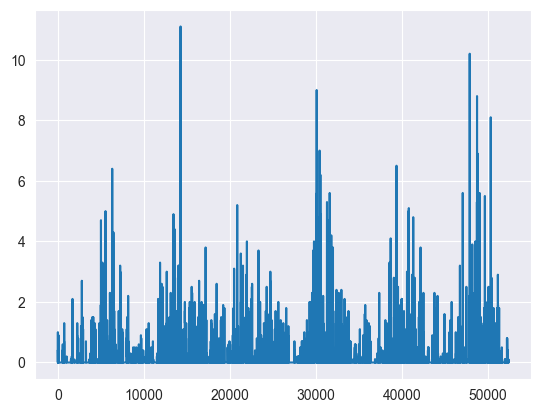

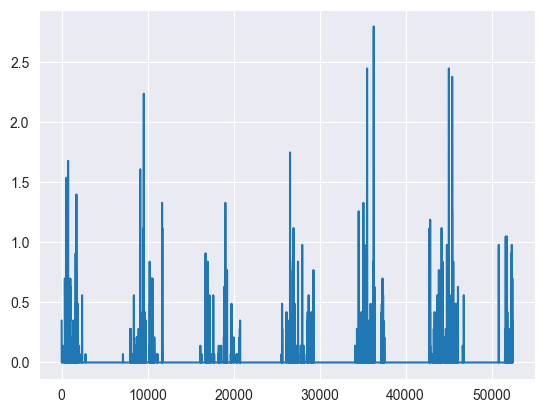

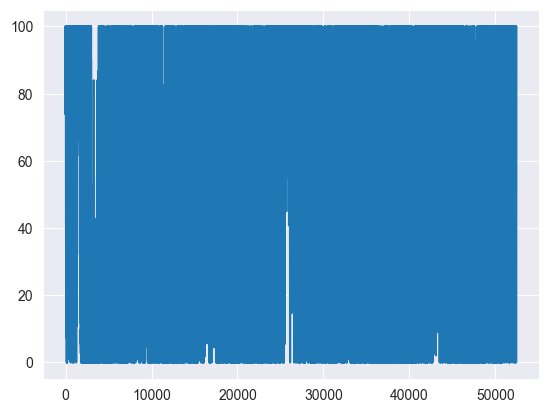

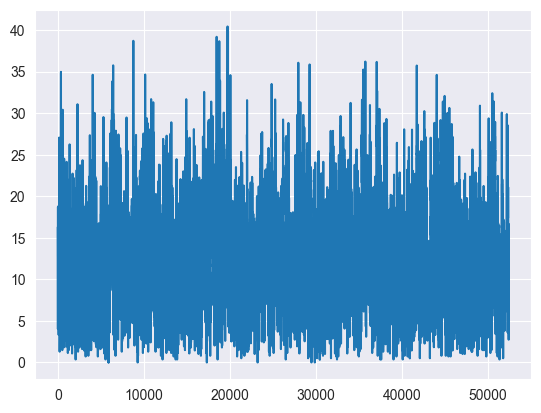

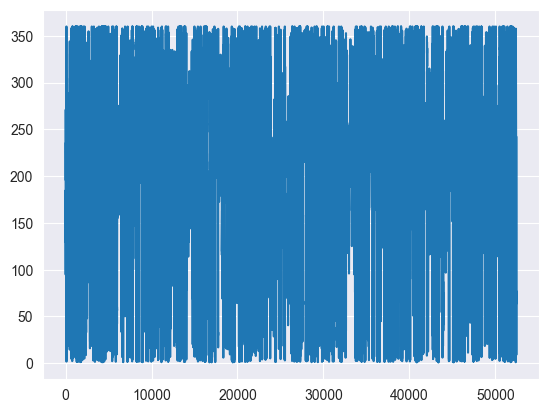

In [5]:
# Try plotting the temperature to see if it makes sense
plot_x = [i for i in range(len(hourly_data["apparent_temperature"]))]
plt.plot(plot_x, hourly_data["apparent_temperature"], label='Temp apparent')
plt.plot(plot_x, hourly_data["temperature_2m"], label='Temp 2m')
plt.legend()
plt.xlabel('Arbitrary time')
plt.ylabel('Temperature')
plt.show()
# We can see that the temperature is much higher during summer, everything looks good
# Let's check pressure, snow, clouds and rain.

plt.plot(plot_x, hourly_data['surface_pressure'], label='Temp apparent')
plt.show()

plt.plot(plot_x, hourly_data['rain'], label='Temp apparent')
plt.show()

plt.plot(plot_x, hourly_data['snowfall'], label='Temp apparent')
plt.show()

plt.plot(plot_x, hourly_data['cloud_cover'], label='Temp apparent')
plt.show()

plt.plot(plot_x, hourly_data['wind_speed_10m'], label='Temp apparent')
plt.show()

plt.plot(plot_x, hourly_data['wind_direction_10m'], label='Temp apparent')
plt.show()

<Axes: >

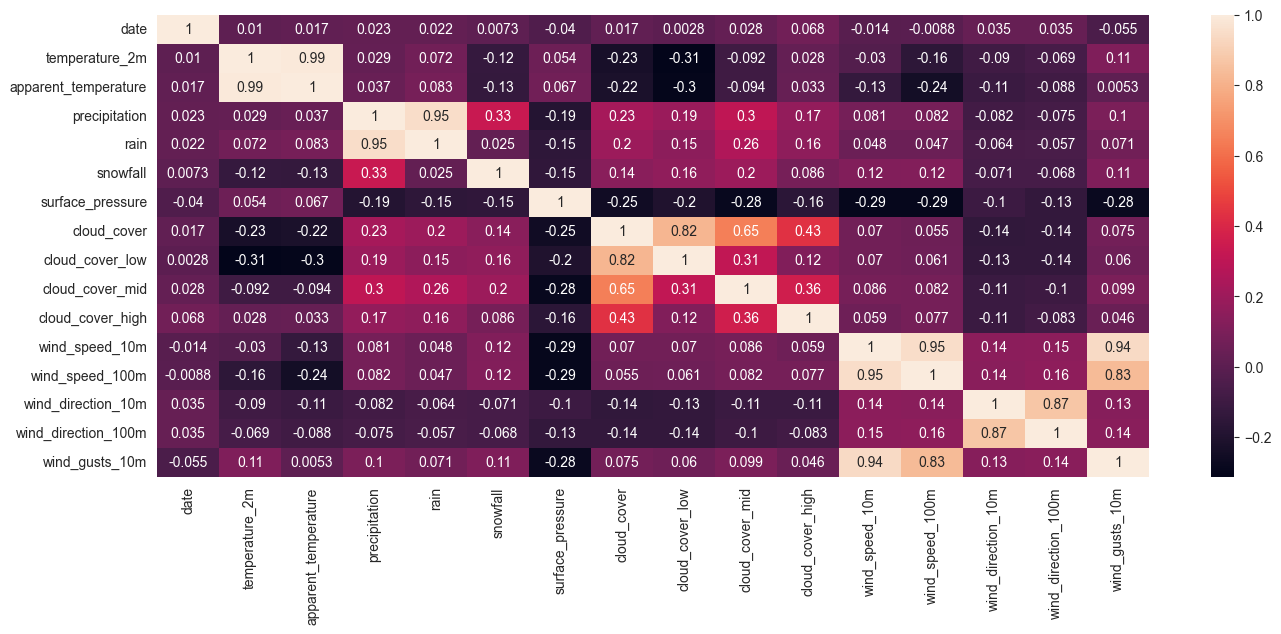

In [6]:
plt.figure(figsize=(16, 6))
sns.heatmap(hourly_dataframe.corr(), annot=True)

In [7]:
# We see that windspeeds/windgusts at different heights correlate highly, and thus isn't as interesting. We remove these.
hourly_dataframe = hourly_dataframe.drop(columns=['wind_speed_100m', 'wind_direction_100m', 'wind_gusts_10m'])
# Furthermore, the different cloud coverage - low, mid and high are not very interesting either. We remove these and keep the cloud coverage variable
hourly_dataframe = hourly_dataframe.drop(columns=['cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high'])
# We'll remove precipition as it is a combination of rain and snowfall.
hourly_dataframe = hourly_dataframe.drop(columns=['precipitation'])

## Encoding Cyclical Nature of Dates

In many datasets, dates and times are crucial features, but their standard numerical representations can be misleading for machine learning models. This is because time variables like days and hours are cyclical. For example, in a yearly cycle, day 1 (January 1st) is very close to day 365 (December 31st), but their numeric values are far apart. A similar concept applies to hours in a day.

To accurately represent this cyclical nature, we use sine and cosine functions to encode the days of the year and the hours of the day. This transformation maps these time features onto a circle, ensuring that values close in time are also close in their transformed space. This method enhances the model's ability to recognize and utilize these temporal relationships during training.

In [8]:
from utils import *

# Encode day of year and time of day into cyclical representations
hourly_dataframe['day_cos'], hourly_dataframe['day_sin'] = encode_cycle(hourly_dataframe['date'].dt.dayofyear, 365)
hourly_dataframe['hour_cos'], hourly_dataframe['hour_sin'] = encode_cycle(hourly_dataframe['date'].dt.hour, 24)

# We no longer need to keep the full date, since we don't really care about what year it is (though we really should due to global warming for example). However, we'll keep it for indexing since uploading to hopsworks does not seem to preserve the order of the data.

print(hourly_dataframe)

                     date  temperature_2m  apparent_temperature  rain  \
0     2017-12-31 23:00:00           1.265             -3.031214   0.4   
1     2018-01-01 00:00:00           1.365             -2.281977   0.4   
2     2018-01-01 01:00:00           2.015             -1.806996   0.2   
3     2018-01-01 02:00:00           2.465             -1.194924   0.0   
4     2018-01-01 03:00:00           2.865             -0.409620   0.0   
...                   ...             ...                   ...   ...   
52435 2023-12-25 18:00:00          -0.185             -3.219042   0.0   
52436 2023-12-25 19:00:00          -0.235             -3.228180   0.0   
52437 2023-12-25 20:00:00          -0.385             -3.208137   0.0   
52438 2023-12-25 21:00:00          -0.535             -3.178375   0.0   
52439 2023-12-25 22:00:00          -0.635             -3.888433   0.0   

       snowfall  surface_pressure  cloud_cover  wind_speed_10m  \
0          0.35        990.038391        100.0       16.2

## Feature store
Add the fine-tuned dataset to the feature store.

In [9]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/191638
Connected. Call `.close()` to terminate connection gracefully.


In [10]:
weather_fg = fs.get_or_create_feature_group(
    name="weather",
    version=1,
    primary_key=['date', 'temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'surface_pressure', 'cloud_cover', 'wind_speed_10m', 'wind_direction_10m', 'day_cos', 'day_sin', 'hour_cos', 'hour_sin'],
    description="Weather dataset")

weather_fg.insert(hourly_dataframe)


Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/191638/fs/191557/fg/387464


Uploading Dataframe: 0.00% |          | Rows 0/52440 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: weather_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/191638/jobs/named/weather_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x2eee7b196d0>, None)